In [1]:
PATH='/home/kirana/Documents/phd/exp3_autoencoder'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/bookcrossing'

In [2]:
import pandas as pd
import numpy as np
import os
import datetime
import sklearn
import torch
import pickle
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [3]:
[df, df_train,df_valid,df,df_ratings,idx_to_user,\
             idx_to_movie,movie_to_idx,user_to_idx]=pickle.load(open(f'{DATAPATH}/itemreads.pkl','rb'))

## Dataset and DataLoader

In [4]:
class autoencdata (Dataset):
    def __init__(self,dfX,dfXv):
        self.dfX,self.dfXv=dfX,dfXv
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.FloatTensor(self.dfX[idx].todense().getA1()),torch.FloatTensor(self.dfXv[idx].todense().getA1())

In [5]:
dstrain=autoencdata(df_train, df_valid)
#dsvalid=autoencdata(df_valid)

In [6]:
df_train.shape

(340557, 105284)

In [7]:
bs=64

In [8]:
# Create a DataLoader object
dltrain=DataLoader(dstrain,batch_size=bs,shuffle=False)
#dlvalid=DataLoader(dsvalid,batch_size=bs,shuffle=False) 

In [9]:
df['rating'].min(),df['rating'].max()

(0, 10)

In [10]:
df_train.shape

(340557, 105284)

In [11]:
len(dltrain)

5322

## Create the Model Architecture for the Encoder

In [12]:
def hidden_layer(x,y,dropout,activation=nn.Sigmoid()):
    return nn.Sequential(
        nn.Linear(x, y),
        activation,
        nn.Dropout(p=dropout)
        )   

In [13]:
class autoencoder (nn.Module):    
    def __init__(self,n_inp,hidden=[50,10],dropouts=[0,0,0],rating_range=[0.5,5]):
        super().__init__()
        self.n_inp,self.hidden,self.dropouts,self.rating_range=n_inp,hidden,dropouts,rating_range
        encoder=[hidden_layer(n_inp if i==0 else hidden[i-1],hidden[i],dropouts[i],\
                              nn.Sigmoid() if i<len(hidden)-1 else nn.Tanh()) for i in range(len(hidden))]
        self.encoder=nn.Sequential(*encoder)
        hidden=hidden[::-1]
        num_steps=len(hidden)-1
        dropouts=dropouts[num_steps:]
        decoder=[hidden_layer(hidden[i],hidden[i+1] if i<len(hidden)-1 else n_inp,dropouts[i]) for i in range(len(hidden)-1)]
        self.decoder=nn.Sequential(*decoder)
        self.fc=nn.Linear(hidden[-1],n_inp)
        self.initialize()
        self.criterion=nn.MSELoss()
    
    def initialize(self):
        for x in self.encoder:
            nn.init.kaiming_normal_(x[0].weight.data)
        for x in self.decoder:
            nn.init.kaiming_normal_(x[0].weight.data)

    def forward (self,Xb):
        
        encoded=self.encoder(Xb)
        decoded=self.decoder(encoded)
        out=self.fc(decoded)
        outv=out.clone()
        out[Xb==0]=0
        loss=self.criterion(out,Xb)
        return outv,loss, out

In [18]:
n_item_final=25

In [21]:
autoenc=autoencoder(df_train.shape[1],[n_item_final*5,n_item_final],[0,0,0])

In [22]:
autoenc

autoencoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=105284, out_features=125, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0)
    )
    (1): Sequential(
      (0): Linear(in_features=125, out_features=25, bias=True)
      (1): Tanh()
      (2): Dropout(p=0)
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=25, out_features=125, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0)
    )
  )
  (fc): Linear(in_features=125, out_features=105284, bias=True)
  (criterion): MSELoss()
)

In [23]:
for Xb, Xb_v in dltrain:
    print (Xb)
    break

tensor([[7., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 9.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [24]:
Xb.size()

torch.Size([64, 105284])

In [25]:
Xb.squeeze(0)

tensor([[7., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 9.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [26]:
preds,loss,preds_train=autoenc.forward(Xb)

In [27]:
loss.backward()

In [28]:
preds.size()

torch.Size([64, 105284])

In [29]:
nn.MSELoss

torch.nn.modules.loss.MSELoss

In [30]:
device="cuda:0"

In [31]:
wd=1e-4
#wd=1e-1

In [32]:
optimizer=torch.optim.Adam(autoenc.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
#optimizer=torch.optim.SGD(model_sentiment.parameters(),lr=1e-2,momentum=0.9, weight_decay=wd)
metric_fn=None

In [33]:
len(dltrain)

5322

In [34]:
import matplotlib.pyplot as plt

In [35]:
dltrain.batch_size

64

In [36]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=6,start_lr=2e-2, end_lr=5e-4):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        
    def fit (self,Xb,Xb_v,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss,preds_train=self.model(Xb)
        # denominator is the average of the error with non-zero ratings

        mean_corrector = Xb.size(0)*Xb.size(1)/(torch.sum(Xb > 0).float() + 1e-10)
        mean_corrector_v = Xb_v.size(0)*Xb_v.size(1)/(torch.sum(Xb_v > 0).float() + 1e-10)

        with torch.no_grad():
            
            preds[Xb_v==0]=0
            loss_v=self.model.criterion(preds,Xb_v)
            
            if self.metric_fn is not None:
                acc=self.metric_fn(preds,Yb.view(-1),self.device)
                acc=acc.item()

                if 1==0:
                    if mode_train:
                        self.trainY.append(Yb.view(-1))
                        self.preds.append(preds.data)
                    else:
                        self.actual.append(Yb.view(-1))
                        self.preds_valid.append(preds.data)
            else:
                acc=0
                acc_v=0
            del preds
        
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=torch.sqrt(loss.item()*mean_corrector)
        myloss_v=torch.sqrt(loss_v.item()*mean_corrector_v)
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc,myloss_v,acc_v
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0
        epoch_loss_v,epoch_acc_v=0,0

        for Xb,Xb_v in iterator:
            Xb=Xb.to(self.device)
            Xb_v=Xb_v.to(self.device)
            #Xb=Xb.squeeze(0)
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            

            loss,acc,loss_v,acc_v=self.fit(Xb,Xb_v,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)
            
            epoch_loss+=loss
            epoch_acc+=acc
            epoch_loss_v+=loss_v
            epoch_acc_v+=acc_v
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)} {epoch_loss_v/(k)} ')  
                    torch.cuda.empty_cache()
        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
        epoch_loss_v=epoch_loss_v/len(iterator)
        epoch_acc_v=epoch_acc_v/len(iterator)
            
        return epoch_loss,epoch_acc,epoch_loss_v,epoch_acc_v
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):
        
        
            
        
        for epoch in range(n_epochs):                

            loss,acc,lossv,accv=self.run_epoch(dltrain,True)
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss}  Valid Loss:{lossv} ')
  
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    #self.wd=self.start_wd
                    self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    #    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                #param_group['weight_decay']=self.wd
          
     

In [37]:
autoenc=autoencoder(df_train.shape[1],[n_item_final*5,n_item_final],[0.6,0.6,0]).to(device)
wd=1e-7
optimizer=torch.optim.Adam(autoenc.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=0)

In [38]:
autoenc

autoencoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=105284, out_features=125, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.6)
    )
    (1): Sequential(
      (0): Linear(in_features=125, out_features=25, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.6)
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=25, out_features=125, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.6)
    )
  )
  (fc): Linear(in_features=125, out_features=105284, bias=True)
  (criterion): MSELoss()
)

In [39]:
len(dltrain)

5322

In [40]:
learner.lr_find(1e-3,3e-1,dltrain,len(dltrain))

Batch:1000 5.377882957458496 5.366921901702881 
Batch:2000 5.025772571563721 4.949130058288574 
Batch:3000 5.216225624084473 4.976219177246094 
Batch:4000 5.523063659667969 5.098730087280273 
Batch:5000 5.861475467681885 5.1899333000183105 


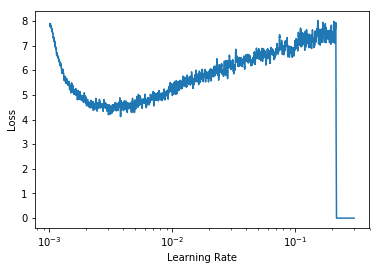

In [41]:
learner.plot_lrs(10)

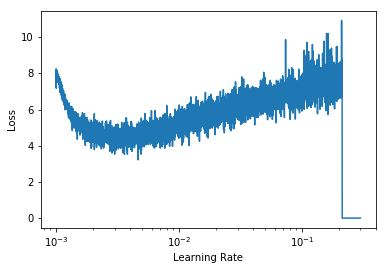

In [42]:
learner.plot_lrs(1)

In [43]:
autoenc=autoencoder(df_train.shape[1],[n_item_final*5,n_item_final],[0.6,0.6,0]).to(device)
wd=1e-7
optimizer=torch.optim.Adam(autoenc.parameters(),lr=2e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=0,start_lr=1e-1,end_lr=5e-2)

In [44]:
learner.run_epochs(dltrain,None,5)

Batch:1000 4.965987205505371 4.937924385070801 
Batch:2000 4.711282730102539 4.635703086853027 
Batch:3000 4.71439790725708 4.482094764709473 
Batch:4000 4.756015300750732 4.372760772705078 
Batch:5000 4.793219089508057 4.251666069030762 
Epoch:0 Learning rate 0.002 Weight Decay 1e-07 Train Loss:4.505159854888916  Valid Loss:4.32425594329834 
Batch:1000 4.241812705993652 4.2177534103393555 
Batch:2000 4.329883098602295 4.250220775604248 
Batch:3000 4.467310428619385 4.239835739135742 
Batch:4000 4.574558734893799 4.190892219543457 
Batch:5000 4.648106575012207 4.103011131286621 
Epoch:1 Learning rate 0.002 Weight Decay 1e-07 Train Loss:4.368783473968506  Valid Loss:4.200897216796875 
Batch:1000 4.242272853851318 4.212949275970459 
Batch:2000 4.330840587615967 4.253593921661377 
Batch:3000 4.469354629516602 4.236480236053467 
Batch:4000 4.575699806213379 4.195560455322266 
Batch:5000 4.649427890777588 4.111344814300537 
Epoch:2 Learning rate 0.002 Weight Decay 1e-07 Train Loss:4.3700709

In [45]:
torch.save(autoenc,f=f'{DATAPATH}/inter/item_autoenc')
torch.save(learner,f=f'{DATAPATH}/inter/item_autoenc_learner')
torch.save(optimizer,f=f'{DATAPATH}/inter/item_autoenc_optimizer')
torch.save(autoenc.state_dict(),f'{DATAPATH}/inter/item_autoenc_state_dict')
torch.save(optimizer.state_dict(),f'{DATAPATH}/inter/item_autoenc_optimizer_state_dict')

/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [48]:
wd=1e-7
optimizer=torch.optim.Adam(autoenc.parameters(),lr=2e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=2,start_lr=5e-3,end_lr=5e-4)

In [49]:
learner.run_epochs(dltrain,None,7)

Batch:1000 4.744509696960449 4.720917701721191 
Batch:2000 4.594383239746094 4.517027854919434 
Batch:3000 4.638667583465576 4.412087917327881 
Batch:4000 4.701249122619629 4.319840908050537 
Batch:5000 4.750206470489502 4.205956935882568 
Epoch:0 Learning rate 0.002 Weight Decay 1e-07 Train Loss:4.464739799499512  Valid Loss:4.284858226776123 
Batch:1000 4.429960250854492 4.399829387664795 
Batch:2000 4.375687122344971 4.296535015106201 
Batch:3000 4.450942039489746 4.22106409072876 
Batch:4000 4.539220333099365 4.157494068145752 
Batch:5000 4.608821392059326 4.067996978759766 
Epoch:1 Learning rate 0.001 Weight Decay 1e-07 Train Loss:4.331871509552002  Valid Loss:4.138294219970703 
Batch:1000 4.751831531524658 4.734771728515625 
Batch:2000 4.578530788421631 4.498276710510254 
Batch:3000 4.5634284019470215 4.318572998046875 
Batch:4000 4.59481143951416 4.194602966308594 
Batch:5000 4.635807037353516 4.082457542419434 
Epoch:2 Learning rate 0.0005 Weight Decay 1e-07 Train Loss:4.357184

In [50]:
torch.save(autoenc,f=f'{DATAPATH}/inter/item_autoenc')
torch.save(learner,f=f'{DATAPATH}/inter/item_autoenc_learner')
torch.save(optimizer,f=f'{DATAPATH}/inter/item_autoenc_optimizer')
torch.save(autoenc.state_dict(),f'{DATAPATH}/inter/item_autoenc_state_dict')
torch.save(optimizer.state_dict(),f'{DATAPATH}/inter/item_autoenc_optimizer_state_dict')

/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [51]:
item_mtx_1_weights=autoenc.encoder[0][0].weight.data.cpu().numpy()
item_mtx_2_weights=autoenc.encoder[1][0].weight.data.cpu().numpy()

In [52]:
item_mtx_1_weights.shape, item_mtx_2_weights.shape

((125, 105284), (25, 125))

In [53]:
df_train.shape

(340557, 105284)

In [54]:
from scipy.special import expit

df_train_item_autoenc=np.tanh(expit(df_train@item_mtx_1_weights.T)@item_mtx_2_weights.T)
df_valid_item_autoenc=np.tanh(expit(df_valid@item_mtx_1_weights.T)@item_mtx_2_weights.T)

In [55]:
df_train_item_autoenc=expit(df_train@item_mtx_1_weights.T)@item_mtx_2_weights.T
df_valid_item_autoenc=expit(df_valid@item_mtx_1_weights.T)@item_mtx_2_weights.T

In [56]:
df_train_item_autoenc.shape

(340557, 25)

In [57]:
df_valid_item_autoenc.shape

(340557, 25)

In [58]:
df_train_item_autoenc=pd.DataFrame(df_train_item_autoenc)
df_valid_item_autoenc=pd.DataFrame(df_valid_item_autoenc)

In [59]:
autoenc.encoder[0][0].weight.data.shape

torch.Size([125, 105284])

In [60]:
autoenc.encoder[1][0].weight.data.shape

torch.Size([25, 125])

In [61]:
item_mtx_1_weights=autoenc.encoder[0][0].weight.data.cpu().numpy()
item_mtx_2_weights=autoenc.encoder[1][0].weight.data.cpu().numpy()

In [62]:
df_train_item_autoenc.columns=['item_autoenc'+str(i) for i in range(df_train_item_autoenc.shape[1])]

In [63]:
df_valid_item_autoenc.columns=['item_autoenc'+str(i) for i in range(df_valid_item_autoenc.shape[1])]

In [64]:
df_train_item_autoenc.reset_index(inplace=True)

In [65]:
df_valid_item_autoenc.reset_index(inplace=True)

In [66]:
df_train_item_autoenc.rename({'index':'item_idx'},axis=1,inplace=True)
df_valid_item_autoenc.rename({'index':'item_idx'},axis=1,inplace=True)

In [67]:
import pickle
pickle.dump([df_train_item_autoenc, df_valid_item_autoenc,item_mtx_1_weights,item_mtx_2_weights],open(f'{DATAPATH}/inter/item_autoenc_weights.pkl','wb'))